In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
%matplotlib inline

In [1]:
import sys

In [2]:
sys.path.pop(1)

'/opt/ros/kinetic/lib/python2.7/dist-packages'

In [4]:
dir_basis = './00_input/rgb_with_poses/'
files = [file for file in os.listdir(dir_basis) if file[-3:] == 'png']

def create_orb_features(dir_basis, files):
    for file in files:

        filename = dir_basis + file

        img = cv.imread(filename)
        gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        orb = cv.xfeatures2d.SIFT_create()

        kp, descriptors = orb.detectAndCompute(gray, None)

        temp = [(point.pt, point.size, point.angle, point.response, point.octave, 
            point.class_id, desc) for point, desc in zip(kp, descriptors)]

        with open(filename[:-3] + 'pckl', 'wb') as file:
            pickle.dump(temp, file)

In [5]:
create_orb_features(dir_basis, files)

In [6]:
def deserialize_keypoint(point):
    return cv.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], 
                            _response=point[3], _octave=point[4], _class_id=point[5]), point[6]

In [7]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params,search_params)

In [8]:
flann = cv.FlannBasedMatcher(index_params, {})

In [9]:
def get_keypoints(image_file):
    kp1, desc1 = [], []
    with open(image_file[:-3] + 'pckl', 'rb') as file:
        for entry in pickle.load(file):
            k, d = deserialize_keypoint(entry)
            kp1.append(k)
            desc1.append(d)       
    return kp1, np.array(desc1)

In [10]:
fname1 = dir_basis + files[0]
fname2 = dir_basis + files[1]
kp1, desc1 = get_keypoints(fname1)
kp2, desc2 = get_keypoints(fname2)

In [11]:
matches = flann.knnMatch(desc1,desc2,k=2)

In [12]:
matchesMask = [[0,0] for i in range(len(matches))]

good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [13]:
draw_params = {
    'matchColor' : (0,255,0),
    'singlePointColor' : (255,0,0),
    'matchesMask' : matchesMask,
    'flags' : 0
}

In [14]:
img1 = cv.imread(fname1)
img2 = cv.imread(fname2)

In [15]:
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None, **draw_params)

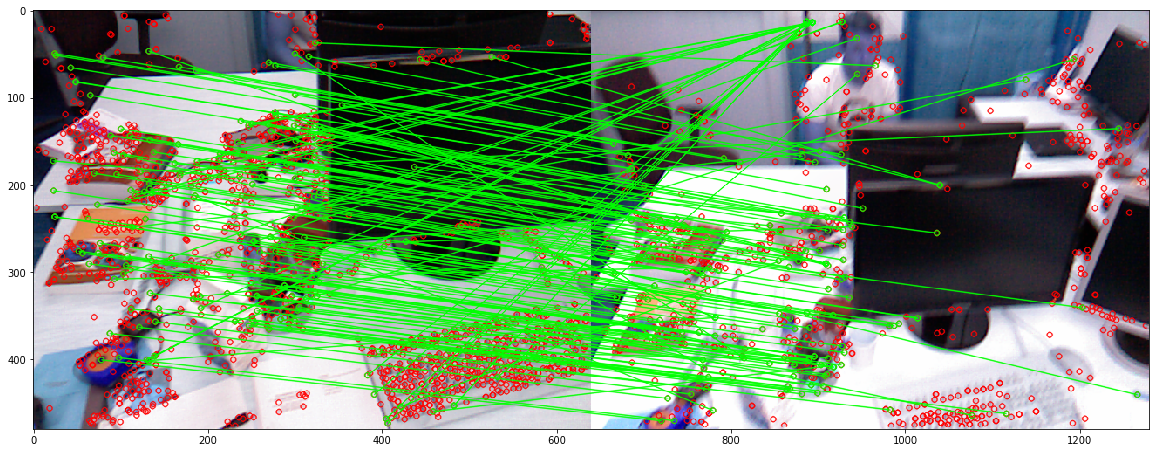

In [16]:
plt.figure(figsize=(20, 10))
plt.imshow(img3)

In [17]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [18]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, _ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2

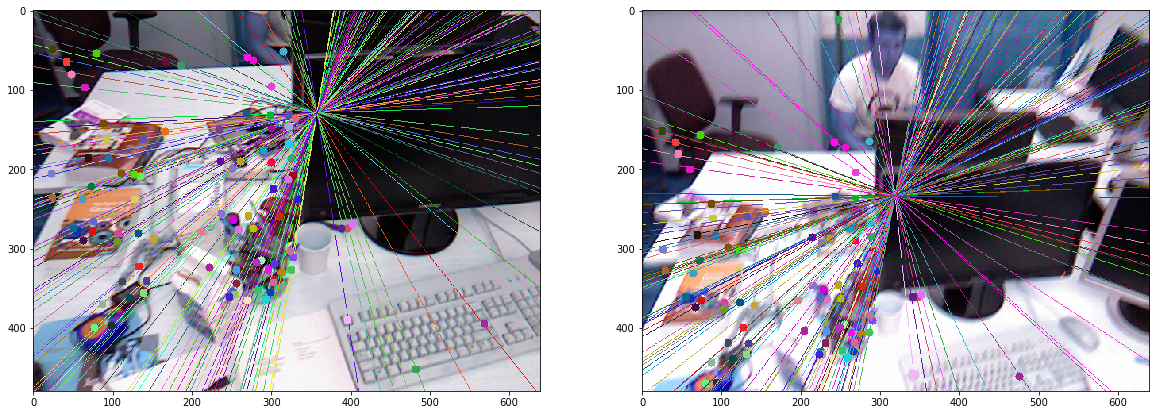

In [19]:
plt.figure(figsize=(20, 10))
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

In [20]:
from itertools import product

def find_correspondences(files):
    # TODO: Save fundamental matrices
    # How to take out 
    
    fname0 = files[0]
    kp0, desc0 = get_keypoints(fname0)
    pts_correspondence = {}

    for i in range(len(files))[1:]:

        fname1 = files[i]
        kp1, desc1 = get_keypoints(fname1)

        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc0,desc1,k=2)

        matchesMask = [[0,0] for i in range(len(matches))]

        good = []
        pts1 = []
        pts2 = []

        # ratio test as per Lowe's paper
        for j, p in enumerate(matches):
            try:
                m, n = p
            except:
                continue
            if m.distance < 0.8 * n.distance:
                matchesMask[j] = [1, 0]
                good.append(m)
                pts2.append(kp1[m.trainIdx])
                pts1.append(kp0[m.queryIdx])

        pts1_coord = np.int32([kp.pt for kp in pts1])
        pts2_coord = np.int32([kp.pt for kp in pts2])

        F, mask = cv.findFundamentalMat(pts1_coord, pts2_coord, cv.FM_RANSAC)
        pts1 = np.array(pts1)[mask.ravel() == 1]
        pts2 = np.array(pts2)[mask.ravel() == 1]

        pts_correspondence[(i-1, i)] = (pts1.copy(), pts2.copy())

        kp0, desc0 = kp1, desc1
        
    return pts_correspondence

pts_correspondence = find_correspondences([dir_basis + file for file in files])

In [142]:
tracks = [[True, 0, [pt1, pt2]] for pt1, pt2 in zip(*pts_correspondence[(0, 1)])]

In [143]:
for i in range(1, len(files) - 1):
    
    taken_points = np.zeros_like(pts_correspondence[(i, i + 1)][0], dtype=bool)
    
    for track in tracks:
        
        has_match = False
        kp = track[-1][-1]
        
        if track[0] == False:
            continue

        for j, kp1 in enumerate(pts_correspondence[(i, i + 1)][0]):
            if np.linalg.norm(np.array(kp.pt) - np.array(kp1.pt)) < kp.size:
                taken_points[j] = True
                if has_match:
                    continue
                has_match = True
                track[-1].append(pts_correspondence[(i, i + 1)][1][j])
        
        track[0] = has_match
    
    for kp_index in np.where(taken_points == False)[0]:
        tracks.append([True, i, [
            pts_correspondence[(i, i + 1)][0][kp_index],
            pts_correspondence[(i, i + 1)][1][kp_index]
        ]])

In [148]:
tracks[3428]
# first entry - finish flag (auxilary stuff)
# second entry - the first frame where the point appears
# third entry - list of keypoints on subsequent images

[False,
 26,
 [<KeyPoint 0x7f55e84afbd0>,
  <KeyPoint 0x7f55e8434bd0>,
  <KeyPoint 0x7f55e83b6660>,
  <KeyPoint 0x7f55e83f7e40>,
  <KeyPoint 0x7f55e846b0f0>,
  <KeyPoint 0x7f55e83a8750>,
  <KeyPoint 0x7f55e8559fc0>]]

In [152]:
def get_poses(filename):
    poses = []
    with open(filename, 'r') as file:
        for line in file:
            if line[0] == '#':
                continue
            poses.append([float(el) for el in line.split()[1:]])
    return np.array(poses)

In [153]:
poses = get_poses('./00_input/known_poses.txt')

In [154]:
def get_calibration_matrix(filename):
    with open(filename, 'r') as file:
        for line in file:
            pass
    data = [float(el) for el in line.split()]
    matrix = np.diag(data[:2] + [1])
    matrix[:-1, -1] = data[-2:]
    return matrix

In [155]:
K = get_calibration_matrix('./00_input/intrinsics.txt')

In [156]:
def quaternion_matrix(quaternion):
    q = np.array(quaternion, dtype=np.float64, copy=True)
    n = np.dot(q, q)
    if n < 1e-6:
        return np.identity(4)
    q *= np.sqrt(2.0 / n)
    q = np.outer(q, q)
    return np.array([
        [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0], 0.0],
        [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0], 0.0],
        [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2], 0.0],
        [                0.0,                 0.0,                 0.0, 1.0]
    ])

In [157]:
succesfull_triangulations = {}

for i, track in enumerate(tracks):
    
    image_coords = np.array([kp.pt for kp in tracks[i][-1]])
    image_indices = np.arange(tracks[i][1], tracks[i][1] + len(tracks[i][-1]))
    
    triangulations = []
    
    for j in range(len(image_indices) - 1):
        
        R = quaternion_matrix(poses[image_indices[j]][-4:])[:-1, :-1]
        t = poses[image_indices[j]][:-4].reshape(-1, 1)

        R_dash = quaternion_matrix(poses[image_indices[j + 1]][-4:])[:-1, :-1]
        t_dash = poses[image_indices[j + 1]][:-4].reshape(-1, 1)
        
        P = K @ np.concatenate((R, t), axis=1)
        P_dash = K @ np.concatenate((R_dash, t_dash), axis=1)
        
        world_point = cv.triangulatePoints(
            P, P_dash,
            image_coords[j].reshape(2, -1), image_coords[j + 1].reshape(2, -1)
        )
        
        rep1 = cv.convertPointsFromHomogeneous(
            (P @ world_point).reshape(-1, 3)
        )
        
        rep2 = cv.convertPointsFromHomogeneous(
            (P_dash @ world_point).reshape(-1, 3)
        )
        
        world_point = cv.convertPointsFromHomogeneous(world_point.reshape(-1, 4))
        triangulations.append(world_point)
        
    triangulation = np.array(triangulations).mean(axis=0)
    world_point = cv.convertPointsToHomogeneous(triangulation).reshape(-1)
    
    for j in range(len(image_indices) - 1):
        
        R = quaternion_matrix(poses[image_indices[j]][-4:])[:-1, :-1]
        t = poses[image_indices[j]][:-4].reshape(-1, 1)

        R_dash = quaternion_matrix(poses[image_indices[j + 1]][-4:])[:-1, :-1]
        t_dash = poses[image_indices[j + 1]][:-4].reshape(-1, 1)
        
        P = K @ np.concatenate((R, t), axis=1)
        P_dash = K @ np.concatenate((R_dash, t_dash), axis=1)
        
        rep1 = cv.convertPointsFromHomogeneous(
            (P @ world_point).reshape(-1, 3)
        )
        
        rep2 = cv.convertPointsFromHomogeneous(
            (P_dash @ world_point).reshape(-1, 3)
        )
        
        if np.linalg.norm(rep1 - image_coords[j]) > 10 or np.linalg.norm(rep2 - image_coords[j + 1]) > 10:
            break
    else:
        continue
        
    succesfull_triangulations[i] = triangulation.reshape(-1)

In [160]:
print(len(tracks))
print(len(succesfull_triangulations.keys()))

5713
4706


In [161]:
unknown_dir = './00_input/rgb/'
files_unknown = [file for file in os.listdir('./00_input/rgb/') if file[-3:] == 'png']
create_orb_features(unknown_dir, files_unknown)

In [162]:
tracks[278]

[False,
 3,
 [<KeyPoint 0x7f55e8546e10>,
  <KeyPoint 0x7f55e84abd20>,
  <KeyPoint 0x7f55e84c43c0>,
  <KeyPoint 0x7f55e84abc30>]]

In [62]:
p = 0
for q in range(50):    
    
    corr = find_correspondences([unknown_dir + files_unknown[p], dir_basis + files[q]])
    
    image_tracks = [track for track in tracks if q in tracks[track][0]]
    image_points = [track for track in image_tracks if tuple(tracks[track][1][
        np.where(tracks[track][0] == q)[0][0]]) in
                set(tuple(pt) for pt in corr[0, 1][1])]
    
    object_pts = np.array([succesfull_triangulations[pt] for pt in image_points if pt in succesfull_triangulations])
    image_points = np.array([tracks[track][1][
        np.where(tracks[track][0] == q)[0][0]] for track in image_points if track in succesfull_triangulations])
    origin_points = np.array([point for i, point in enumerate(corr[0, 1][0]) if tuple(corr[0, 1][1][i])
                     in set([tuple(pt) for pt in image_points])]).astype(float)
    
    if len(origin_points) < 5:
        continue

    flag, rvec, tvec, inliers = cv.solvePnPRansac(object_pts, origin_points, K, np.array([]))
    
    if not flag:
        continue
        
    reproj = cv.convertPointsFromHomogeneous(
        (K @ np.concatenate((rot, tvec), axis=1) @ cv.convertPointsToHomogeneous(object_pts).reshape(-1, 4).T).T
    ).astype(int)
    
    reproj = reproj.reshape(-1, 2)
    print(q)
    norms = np.linalg.norm(reproj - origin_points, axis=1)

error: /home/divserge/opencv/modules/calib3d/src/solvepnp.cpp:252: error: (-215) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function solvePnPRansac


In [138]:
norms

array([ 47.42362281, 126.01983971,   1.        ,   2.23606798,
        18.43908891,   1.41421356,   6.        ,   7.21110255,
         4.24264069,  64.49806199])

In [108]:
flag

True

In [127]:
rot = cv.Rodrigues(rvec)[0]

In [128]:
reproj = cv.convertPointsFromHomogeneous(
    (K @ np.concatenate((rot, tvec), axis=1) @ cv.convertPointsToHomogeneous(object_pts).reshape(-1, 4).T).T
).astype(int)

error: /home/divserge/opencv/modules/calib3d/src/fundam.cpp:952: error: (-215) npoints >= 0 in function convertPointsToHomogeneous


In [102]:
reproj.reshape(-1, 2)

array([[160, 364],
       [168, 361],
       [161, 364],
       [163, 364],
       [168, 361],
       [160, 366],
       [167, 361],
       [167, 361],
       [168, 361],
       [160, 364]])

In [101]:
origin_points

array([[195., 332.],
       [152., 236.],
       [162., 364.],
       [161., 365.],
       [182., 373.],
       [161., 367.],
       [173., 361.],
       [161., 365.],
       [171., 358.],
       [168., 300.]])